# Summary

Exploratory data analysis of basic card features (e.g. power and toughness)

# Explore Card Table

Time to load up the card data (`cards.parquet`) and take a look at the columns and data types.  We will explore the various data columns.

The file has 96,216 records of cards, with each having 78 data fields.

In [ ]:
# Setup Notebook
import os
if os.path.basename(os.getcwd()) != 'mtg-modeling':
    %run -i "../../scripts/notebook_header.py"

In [ ]:
import pandas as pd
import numpy as np
import pathlib
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [5, 3]

PATH = pathlib.Path("../../data/raw/mtgjson/AllPrintingsParquetFiles/cards.parquet")
df = pd.read_parquet(PATH)
print(f"Loaded DF of shape: {df.shape}")
print(f"\nColumns: {df.columns}")

Loaded DF of shape: (96216, 78)

Columns: Index(['artist', 'artistIds', 'asciiName', 'attractionLights', 'availability',
       'boosterTypes', 'borderColor', 'cardParts', 'colorIdentity',
       'colorIndicator', 'colors', 'defense', 'duelDeck', 'edhrecRank',
       'edhrecSaltiness', 'faceConvertedManaCost', 'faceFlavorName',
       'faceManaValue', 'faceName', 'finishes', 'flavorName', 'flavorText',
       'frameEffects', 'frameVersion', 'hand', 'hasAlternativeDeckLimit',
       'hasContentWarning', 'hasFoil', 'hasNonFoil', 'isAlternative',
       'isFullArt', 'isFunny', 'isOnlineOnly', 'isOversized', 'isPromo',
       'isRebalanced', 'isReprint', 'isReserved', 'isStarter',
       'isStorySpotlight', 'isTextless', 'isTimeshifted', 'keywords',
       'language', 'layout', 'leadershipSkills', 'life', 'loyalty', 'manaCost',
       'manaValue', 'name', 'number', 'originalPrintings',
       'originalReleaseDate', 'originalText', 'originalType', 'otherFaceIds',
       'power', 'printings'

## Exploring Data Features

Here I'll explore the various data feature is the card data.

### Identifier Features
- `uuid`: 
- Also see the `cardIdentifiers.parquet` file

### Name Features
- `asciiName`: Name with only legal ASCII characters.  Only populated if non-ASCII characters in `name`
- `flavorName`: Promotion name, with true name underneath, such as Cabal Coffers with the flavor name: [Minas Morgul](https://scryfall.com/card/ltc/360/cabal-coffers)
- `name`: Name of the cards.  Multi-faced cards include a `//` delimiter.
- `number`: Card number in the set
- `setCode`: The set code a card is in
- Also see the `sets.parquet` file for set data.

#### ASCII Name

Look at the `name` and `asciiName` columns to see if there are any differences.

In [ ]:
df.loc[df['asciiName'] == 'Nazgul', ['asciiName', 'name']].head(1)

,asciiName,name
41669,Nazgul,Nazgûl


#### Set Code

Here is the sets with the top 10 highest counts of `uuid`s.

In [ ]:
counts = df['setCode'].value_counts()
counts[:10]

setCode
PLST    4853
PRM     3200
SLD     1612
WHO     1186
PIP     1076
CMM     1068
CLB      972
LTR      856
J22      835
PSAL     725
Name: count, dtype: int64

A histogram of the set card counts.  It is bimodal with a peak around 200 cards, and a peak around 10 cards.

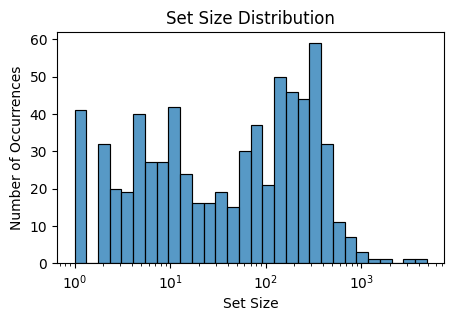

In [ ]:
bins = counts.value_counts()
g = sns.histplot(counts, bins=30, log_scale=[True, False], cbar=True)
g.set(xlabel="Set Size", ylabel="Number of Occurrences", title="Set Size Distribution")
plt.show()

#### Card Name

See how many occurrences of each name there are in the data set.

The five basic lands show up very frequently.

In [ ]:
counts = df['name'].value_counts()
counts[:5]

name
Forest      872
Swamp       845
Island      835
Mountain    833
Plains      810
Name: count, dtype: int64

Here are the next 10 frequent cards, including `Sol Ring` and `Swords to Plowshares`

In [ ]:
counts[5:16]

name
Sol Ring                92
Swords to Plowshares    85
Command Tower           78
Counterspell            71
Evolving Wilds          68
Serra Angel             60
Terramorphic Expanse    59
Lightning Bolt          58
Arcane Signet           58
Giant Growth            57
Disenchant              56
Name: count, dtype: int64

Plotting out the histogram of card name frequency, we can see it follows the power-law.  It is nearly linear on a log-log scale.

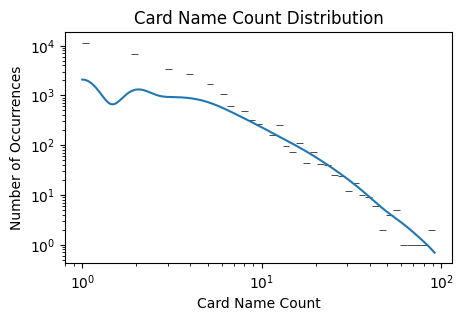

In [ ]:
g = sns.histplot(counts[5:], log_scale=[True, True], kde=True, kde_kws={"bw_adjust": 2})
g.set(xlabel="Card Name Count", ylabel="Number of Occurrences", title="Card Name Count Distribution")
plt.show()

### Primary Play Features
- `keywords`: A list of keywords on the card
- `power`: The power of a creature card
- `rarity`: The rarity of the card
- `toughness`: The toughness of a creature card

#### Keywords

Get count of all keywords in the data.  There are 588 unique keywords.  We can see `flying` takes the lead, with `enchant` and `trample` also being popular.

We'll adjust the data to only look at one of each unique name and removing alterative art cards.

In [ ]:
df_1st = df[df['isAlternative'] != True]
df_1st = df_1st.groupby('name').first()

In [ ]:
counts = df_1st['keywords'].str.split(', ').explode().value_counts()
print(f"Total Unique Keywords: {counts.count()}")
print(f"Keywords w/ >250 Counts: {counts[counts>250].count()}")
print(f"Keywords w/ <10 Count: {counts[counts<10].count()}")
counts[:10]

Total Unique Keywords: 586
Keywords w/ >250 Counts: 18
Keywords w/ <10 Count: 349


keywords
Flying          2746
Enchant         1175
Trample          816
Haste            566
Vigilance        544
Equip            494
Flash            493
Mill             469
Scry             396
First strike     349
Name: count, dtype: int64

Here we see that most keywords are infrequent, with only 18 keywords appearing more than 250 times.

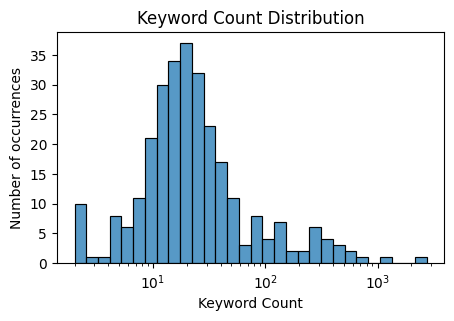

In [ ]:
counts2 = counts[counts>1]
g = sns.histplot(counts2, bins=30, log_scale=True)
g.set(xlabel="Keyword Count", ylabel="Number of occurrences", title="Keyword Count Distribution")
plt.show()

#### Rarity

We can see that for `uuid`s, the `rare` is the most common type.  

In [ ]:
counts = df['rarity'].value_counts()
counts

rarity
rare        35408
common      28389
uncommon    23844
mythic       8179
special       387
bonus           9
Name: count, dtype: int64

We clean this up by only selecting one instance of each name, and removing alterative art cards.

The number of cards per rarity is fairly uniform except for `mythic` which is much lower.  Note that this is the number of uniquely named cards, not print frequency.

In [ ]:
counts = df_1st['rarity'].value_counts()
counts

rarity
common      9941
rare        9256
uncommon    8657
mythic      1788
special        9
Name: count, dtype: int64

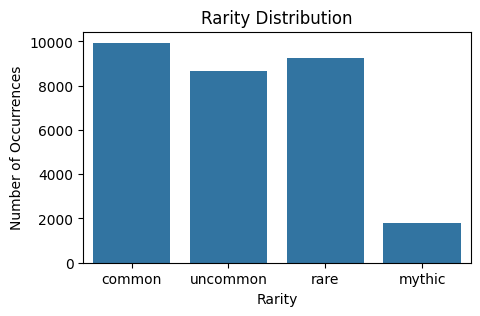

In [ ]:
g = sns.barplot(x=counts.index, y=counts.values, order=['common', 'uncommon', 'rare', 'mythic'])
g.set(xlabel="Rarity", ylabel="Number of Occurrences", title="Rarity Distribution")
plt.show()

#### Power & Toughness

In [ ]:
def select_numeric(counts, col='power'):
    counts = counts.reset_index()
    mask = counts[col].apply(lambda x: x.isnumeric())
    counts = counts[mask]
    counts[col] = counts[col].astype(int)
    counts.sort_values(col, inplace=True)
    counts = counts[counts[col] < 12]
    counts['label'] = col
    counts.rename(columns={col: 'value'}, inplace=True)
    return counts

def count_values(df, col='power'):
    counts = df[col].value_counts()
    return select_numeric(counts, col=col)

def group(df, col1='power', col2='toughness'):
    return pd.concat([count_values(df, col1), count_values(df, col2)])

counts = group(df_1st, col1='power', col2='toughness')

<Axes: xlabel='value', ylabel='count'>

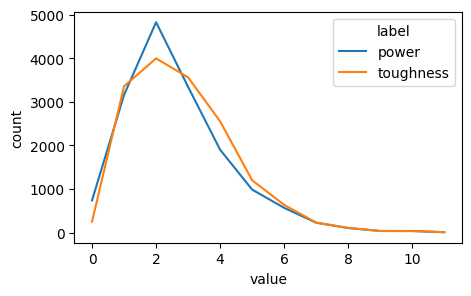

In [ ]:
sns.lineplot(data=counts, x='value', y='count', hue='label')

In [ ]:
df_pl['power']

name
"Ach! Hans, Run!"                 None
"Brims" Barone, Midway Mobster       5
"Lifetime" Pass Holder               2
"Name Sticker" Goblin                2
"Rumors of My Death . . ."        None
                                  ... 
Éomer, King of Rohan                 2
Éomer, Marshal of Rohan              4
Éowyn, Fearless Knight               3
Éowyn, Lady of Rohan                 2
Éowyn, Shieldmaiden                  5
Name: power, Length: 29651, dtype: object

<Axes: xlabel='power', ylabel='toughness'>

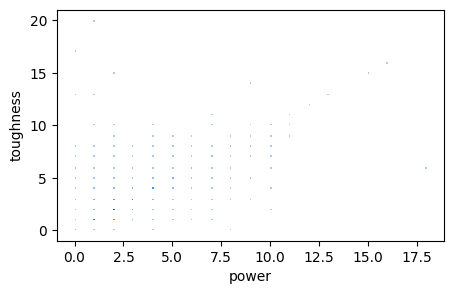

In [ ]:
df_pl = df_1st[['power', 'toughness']].copy()
df_pl.dropna(inplace=True)
df_pl['p_mask'] = df_pl['power'].apply(lambda x: x.isnumeric())
df_pl['t_mask'] = df_pl['toughness'].apply(lambda x: x.isnumeric())
df_pl = df_pl[df_pl['p_mask'] & df_pl['t_mask']]
df_pl['power'] = df_pl['power'].astype(int)
df_pl['toughness'] = df_pl['toughness'].astype(int)
sns.histplot(data=df_pl, x='power', y='toughness')

### Color & Mana Features
- `colorIdentity`
- `colorIndicator`
- `colors`
- `manaCost`
- `manaValue`

### Card Type Features
- `subsets`
- `subtypes`
- `supertypes`
- `type`
- `types`

### Text Features
- `flavorText`:
- `hasContentWarning`: Cards that have sensitive content.  See this [article](https://magic.wizards.com/en/articles/archive/news/depictions-racism-magic-2020-06-10) for more.
- `language`: The language the text is written in.
- `isFunny`: Is a funny card, like in 'Un-sets'
- `isStorySpotlight`: A [Story Spotlight](https://mtg.fandom.com/wiki/Story_Spotlight) card.  Marked as "Story Spotlight" with sequence number in lower border.
- `isTextless`: The card does not have a textbox
- `text`: The rules text in the textbox.
- Also see the `cardRulings.parquet` file for ruling text
- Also see the `cardForeignData.parquet` file foreign language translations


### Special Play Features
- `attractionLights`: List of attraction lights found on cards, such as Unfinity attraction ride cards
- `defense`: Used by `Battle - Siege` type cards, such as `Invasion of Gobakhan // Lightshield Array`
- `hand`: Adjusts starting hand value.  Used by `Vanguard` type cards.
- `hasAlternativeDeckLimit`: Allows for more than 4 copies in a deck
- `leadershipSkills`: Legality of a card to be a commander in various formats
- `loyalty`: Used by planeswalkers
- `life`: Adjusts starting life value.  Used by `Vanguard` type cards.
- `relatedCards`: A list of card names associated to a card, such as `Sword of Dungeons & Dragons` and `Dragon`


### Card Layout Variant Features
- `cardParts`: List of multiple card parts for [meld](https://mtg.fandom.com/wiki/Meld?so=search) layouts, such as `Brisela, Voice of Nightmares` + `Bruna, the Fading Light // Brisela, Voice of Nightmares`
- `faceConvertedManaCost`
- `faceFlavorName`
- `faceManaValue`
- `faceName`
- `layout`: Non-standard card layouts, such as split, flip, or transform
- `otherFaceIds`: `uuid` of other faces of the card, such as double-faced cards.
- `side`: Identifier on side of card for given face, such as `a` or `b`

### Performance Features
- `edhrecRank`
- `edhrecSaltiness`

### Legal Features
- Also see the `cardLegalities.parquet` file for format legalities

### Visual & Collector Features
- `artist`
- `artistIds`
- `borderColor`: Boarder color of card, such as black, white, or silver
- `finishes`: Card finish, such as foil, non-foil, or etched
- `frameEffects`: Non-standard effects, such as etched or extended art
- `frameVersion`: Version of frame such as 1993 or 2015
- `hasFoil`
- `hasNonFoil`
- `isAlternative`
- `isFullArt`
- `isOversized`
- `isTimeshifted`: [Timeshifted](https://mtg.fandom.com/wiki/Timeshifted) is a current card with a retro frame.
- `signature`
- `variations`: `uuid`s of other cards that are alternate printings of the card in the same set.
- `watermark`: Name of [watermark](https://mtg.fandom.com/wiki/Watermark) on the card

### Printing Features
- `availability`: A lest of card's available printing types, such as paper, arena, etc.
- `isOnlineOnly`
- `isPromo`
- `isRebalanced`
- `isReprint`
- `isReserved`
- `printings`
- `promoTypes`
- `rebalancedPrintings`
- `securityStamp`: Security stamp, such as acorn, heart, etc.

### Original Printing Features
- `originalPrintings`: `uuid`s of original printings if its different than the original, such as rebalanced cards.
- `originalReleaseDate`: If release date was different than the set release date.
- `originalText`
- `originalType`

### Products Features
- `boosterTypes`: List of booster types.  Default is a random booster, versus deck boosters which are deterministic.
- `duelDeck`: Indicates which deck ('a' vs 'b') a card is in [Dual Decks](https://mtg.fandom.com/wiki/Duel_Decks)
- `isStarter`: Is card in a starter deck product.
- `sourceProducts`: `uuid`s of associated sealed products where card can be found.
- Also see the `cardPrices.parquet` file for card prices.
- Also see the `cardPurchaseUrls.parquet` file for card purchase URLs.
- Also see the `setBoosterContents.parquet` and related files for booster pack data.

In [ ]:
mask = df['name'] == 'Boom // Bust'
mask &= df['uuid'] == '7104f01e-0ca6-53e6-873f-ee246015174a'
df.loc[mask, ['faceName', 'name', 'language', 'multiverseId', 'identifiers', 'uuid']].head()

KeyError: "['multiverseId', 'identifiers'] not in index"

Here we can see that each printing of the `Boom // Bust` card has a common `multiverseId` and unique `uuid` across the Boom and Bust faces.

In [ ]:
mask = df['name'] == 'Boom // Bust'
mask &= df['multiverseId'] == 140480.0
df.loc[mask, ['faceName', 'name', 'language', 'multiverseId', 'identifiers', 'uuid']].head()

,faceName,name,language,multiverseId,identifiers,uuid
285143,Boom,Boom // Bust,German,140480.0,"{""multiverseId"": 140480, ""scryfallId"": ""303895...",7104f01e-0ca6-53e6-873f-ee246015174a
285151,Bust,Boom // Bust,German,140480.0,"{""multiverseId"": 140480, ""scryfallId"": ""303895...",94a1683f-deed-5731-bc0a-894075b3fdb2


Most cards are printed in 10 languages beyond english.

In [ ]:
df['uuid'].value_counts().value_counts()

count
10    13194
6      9757
7      8048
8      5111
5      4187
4      3679
9      3237
3      3082
1      3009
2      2629
Name: count, dtype: int64

It appears that Phyrexian is not compatible with the UTF-8 character encoding!

In [ ]:
df.loc[df['language'] == 'Phyrexian', 'text'].head()

116703    |zvEZYCsDFhg.\n|besYf,GvEng,mpreLYv co,LFr2aho...
116704    |pcEnusL.\n+Ⅰ: |co,tuhtZFsDYt,DEEtAGvEnyg,hruP...
157935    |zvEpnrYhm.\n|su,Lecc,CF,CsYPYcs,usFPuuDs²\\²M...
162944                                                 None
169505    |zvEhiUIpenDk zvE&EhclYvh.\n|beCEcs,FgCnUCA Fg...
Name: text, dtype: object

## Identifiers

The `cardIdentifiers.parquet` file contains the [Identifiers](https://mtgjson.com/data-models/identifiers/).  These are used to map the MTGJSON card to other platforms, such as TCG Player or MTG Arena.

The other platforms are:  
 - [Card Kingdom](www.cardkingdom.com): A large-scale card vender
 - [Card Sphere](https://www.cardsphere.com/): A card trading marketplace
 - [Cardmarket](https://www.cardmarket.com/en/Magic): A card marketplace
 - [MTG Arena](https://magic.wizards.com/en/mtgarena): An online environment to play MTG
 - [MTG Online](https://magic.wizards.com/en/mtgo): An online environment to play MTG
 - [WOTC Gather](https://gatherer.wizards.com/): WOTC's official data source.
 - [Scryfall](https://scryfall.com/): Another MTG data source.  Note DFC do not have unique UUIDs.
 - [TGC Player](https://www.tcgplayer.com/): A card marketplace

A note on the `uuids`.  The foil and non-foil versions of a card have unique `uuids`.  To cross-reference the other foil type, use the `mtgjsonFoilVersionId` and `mtgjsonNonFoilVersionId` fields.

In [ ]:
file = files[1]
df = load_by_filename(file)
df.loc[2]

Opening cardIdentifiers.parquet
Loaded DF of shape: (96203, 21)


cardKingdomEtchedId                                         None
cardKingdomFoilId                                           None
cardKingdomId                                             122720
cardsphereFoilId                                              21
cardsphereId                                                  22
mcmId                                                      16166
mcmMetaId                                                    176
mtgArenaId                                                  None
mtgjsonFoilVersionId        8fd4e2eb-3eb4-50ea-856b-ef638fa47f8a
mtgjsonNonFoilVersionId                                     None
mtgjsonV4Id                 9eb2e54c-a12b-5e88-a9c0-d8c84c52d59c
mtgoFoilId                                                 26993
mtgoId                                                     26992
multiverseId                                              129465
scryfallCardBackId          0aeebaf5-8c7d-4636-9e82-8c27447861f7
scryfallId               

In [ ]:
uuids = ['57aaebc1-850c-503d-9f6e-bb8d00d8bf7c', '8fd4e2eb-3eb4-50ea-856b-ef638fa47f8a']
mask = df['uuid'].isin(uuids)
df.loc[mask, ['mtgjsonFoilVersionId', 'mtgjsonNonFoilVersionId', 'uuid']]

,mtgjsonFoilVersionId,mtgjsonNonFoilVersionId,uuid
2,8fd4e2eb-3eb4-50ea-856b-ef638fa47f8a,None,57aaebc1-850c-503d-9f6e-bb8d00d8bf7c
3,None,57aaebc1-850c-503d-9f6e-bb8d00d8bf7c,8fd4e2eb-3eb4-50ea-856b-ef638fa47f8a


## Boosters

df = load_by_filename("setBoosterContents.parquet")
mask = df['setCode'] == 'OTJ'
mask &= df['boosterName'] == 'play'
mask &= df['sheetName'] == 'breakingNews'
df.loc[mask].head(50)

df = load_by_filename("setBoosterContentWeights.parquet")
mask = df['setCode'] == 'OTJ'
mask &= df['boosterName'] == 'play'
df.loc[mask].head(50)

df = load_by_filename("setBoosterSheets.parquet")
mask = df['setCode'] == 'OTJ'
mask &= df['boosterName'] == 'collector'
df.loc[mask].head(50)

df = load_by_filename("setBoosterSheetCards.parquet")
mask = df['setCode'] == 'OTJ'
mask &= df['boosterName'] == 'play'
mask &= df['sheetName'] == 'breakingNews'
df.loc[mask].head(50)